In [1]:
#!pip3 install imgaug
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import pickle
from PIL import Image

Using TensorFlow backend.


Load the google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_PATH = "/content/gdrive/My Drive"
TRAINING_PATH = GDRIVE_PATH + "/behavior_cloning"

!ls '{TRAINING_PATH}'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
images	images2  training


Extract the image paths and steering angles from each image and save into an array. Also, we will normalize the data so that there is no heavy bias on one particular steering angle value. Plot the steering angle distribution into a histogram. 

In [3]:
import glob

image_paths =  []
steering_angles = []

DATA_PATH = TRAINING_PATH + "/images"

filenames = glob.glob(DATA_PATH + "/*.jpg")

#fetch the steering angles corresponding to each image
for filename in filenames:
  # filename_split = filename.split("_")
  # image_path.append(filename_split[0])
  angle = int(filename.split("_")[3][:-4])
  steering_angles.append(angle)
  image_paths.append(filename)
print(steering_angles)
print(len(steering_angles))
print(image_paths)

[90, 90, 89, 87, 88, 86, 81, 82, 85, 84, 83, 80, 79, 70, 71, 72, 74, 76, 77, 73, 75, 78, 69, 68, 71, 72, 73, 69, 67, 65, 70, 66, 66, 68, 67, 74, 76, 84, 80, 82, 79, 81, 75, 83, 77, 78, 85, 86, 89, 90, 87, 88, 93, 92, 91, 94, 95, 96, 103, 100, 101, 98, 99, 97, 105, 102, 104, 107, 106, 113, 115, 110, 108, 114, 111, 109, 112, 116, 115, 106, 112, 114, 110, 111, 109, 113, 108, 107, 105, 104, 103, 97, 102, 100, 101, 99, 95, 98, 96, 94, 93, 91, 90, 92, 89, 84, 86, 85, 87, 88, 83, 82, 73, 77, 81, 76, 78, 74, 80, 75, 79, 72, 71, 70, 68, 69, 67, 67, 65, 70, 66, 68, 66, 69, 72, 71, 77, 75, 73, 74, 76, 80, 79, 78, 81, 82, 91, 85, 86, 90, 87, 83, 84, 89, 88, 92, 93, 96, 95, 94, 97, 98, 102, 100, 99, 101, 103, 104, 107, 108, 109, 105, 109, 110, 109, 106, 109, 108, 107, 98, 102, 106, 103, 105, 104, 97, 101, 100, 99, 96, 94, 86, 92, 91, 95, 93, 90, 85, 88, 89, 87, 84, 85, 87, 89, 88, 86, 88, 87, 86, 89, 90, 85, 84, 78, 77, 82, 80, 82, 83, 83, 81, 81, 79, 80, 81, 84, 86, 83, 76, 91, 87, 88, 90, 89, 92,

Total data: 940
Training Samples: 752
Valid Samples: 188


Text(0.5, 1.0, 'Valid set')

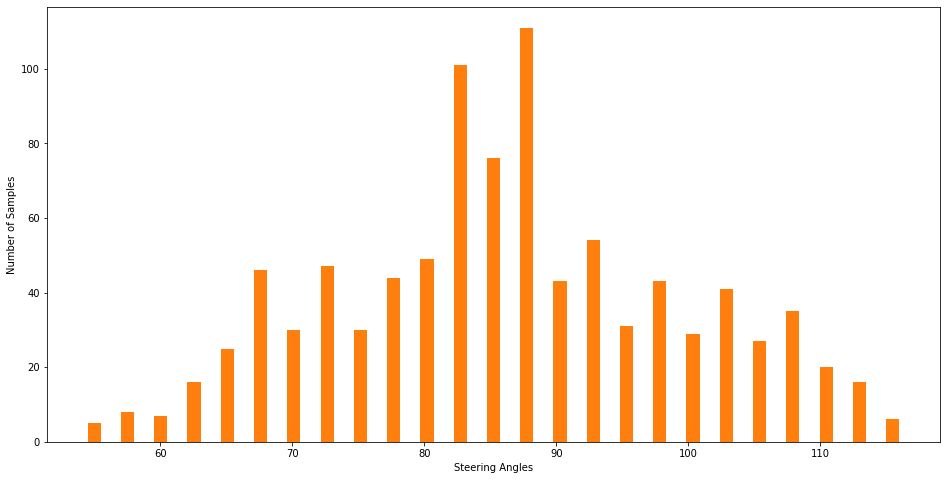

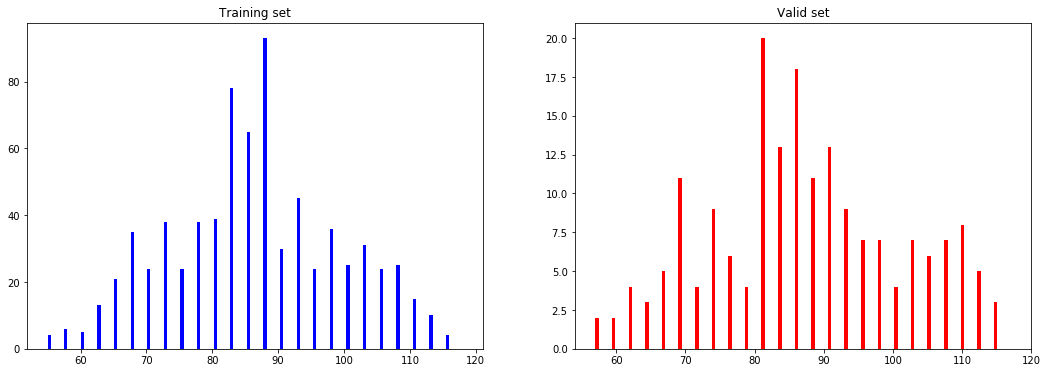

In [4]:
plt.rcParams['figure.figsize'] = (16,8)
# #we do not want the full path to the image, only the tail
# def path_leaf(path):
#   head, tail = ntpath.split(path)
#   return tail


# image_path = image_path.apply(path_leaf)

#plot the steering angles in a histogram
samples_per_bin = 25
num_bins = 25
hist, bins = np.histogram(steering_angles, num_bins)
plt.bar(bins[:-1], hist, width=1)


print("Total data: " + str(len(image_paths)))
#we want to remove oversamples to prevent biases
remove_list = []
# for j in range(num_bins):
#   list_ = []
#   for i in range(len(steering_angles)):
#     if steering_angles[i] >= bins[j] and steering_angles[i] <= bins[j+1]:
#       list_.append(i)
#   list_ = shuffle(list_)
#   #remove samples that number over the threshold
#   list_ = list_[samples_per_bin:] 
#   remove_list.extend(list_)

# list_ = []
# for i in range(len(steering_angles)):
#   if steering_angles[i] >= bins[9] and steering_angles[i] < bins[10]:
#     list_.append(i)
# list_ = shuffle(list_)
# list_ = list_[samples_per_bin:]
# remove_list.extend(list_)

# print("Removing {} samples".format(len(remove_list)))
# # drop the data
# # removing the samples
# steering_angles = np.delete(steering_angles, remove_list)
# image_paths = np.delete(image_paths, remove_list)



hist, bins = np.histogram(steering_angles, num_bins)
plt.bar(bins[:-1], hist, width=1)
plt.ylabel("Number of Samples")
plt.xlabel("Steering Angles")


image_paths = np.asarray(image_paths)
steering_angles = np.asarray(steering_angles)



X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(18,6))
axes[0].hist(y_train, bins=num_bins, width=0.5, color='blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.5, color='red')
axes[1].set_title("Valid set")

TypeError: ignored

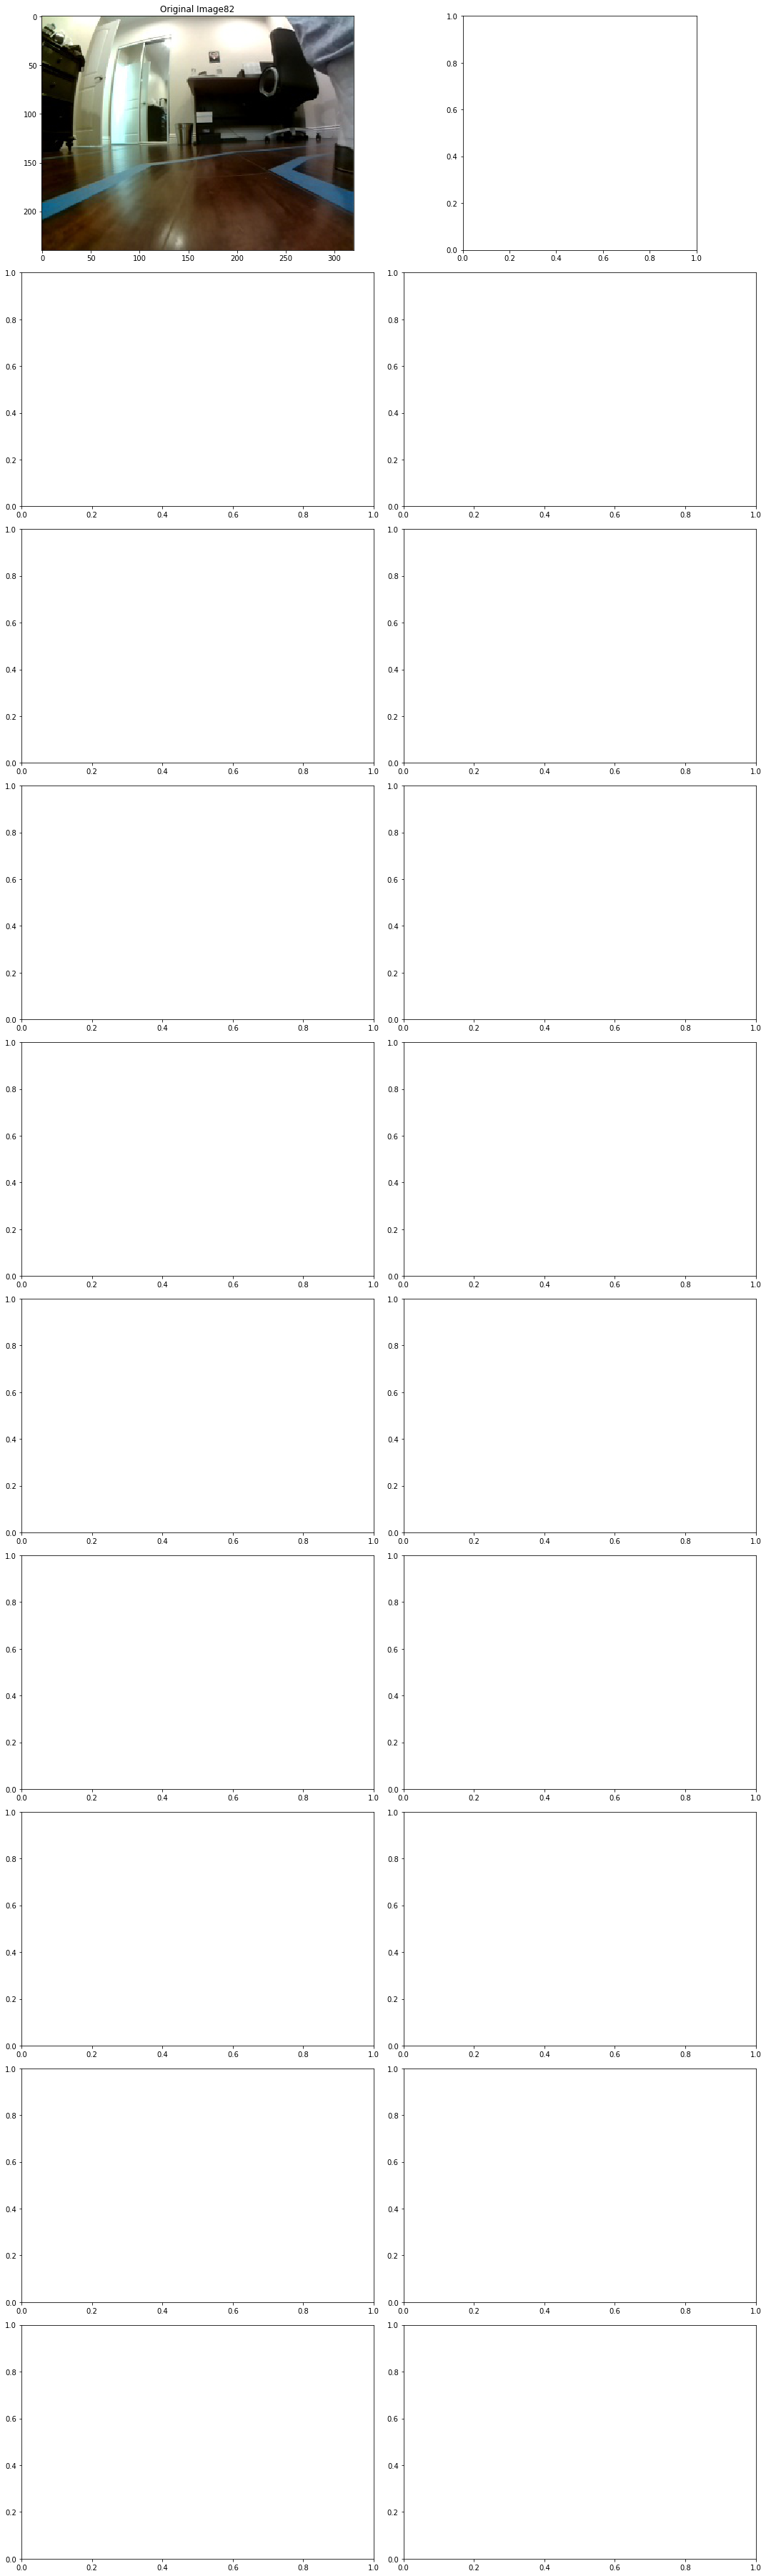

In [5]:
#zoom in the image anywhere from 0-20% 
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.2))
  image = zoom.augment_image(image)
  return image

#shift the image horizontally and/or vertically within a certain range
def translation(image):
  translate = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image= translate.augment_image(image)
  return image

#multiply or brighten/darken each pixel in the image
def multiply(image):
  multiply = iaa.Multiply((0.5, 1.5))
  image = multiply.augment_image(image)
  return image

#flip the image horizontally
def flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = 180 - steering_angle
  return image, steering_angle


def random_augment(image, steering_angle):
  # image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = translation(image)
  if np.random.rand() < 0.5:
    image = multiply(image)
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image, steering_angle)
  return image, steering_angle


cols = 2
rows = 10


fig, axes = plt.subplots(rows, cols, figsize=(15, 50))
fig.tight_layout()

for i in range(rows):
  randnum = random.randint(0, len(image_paths)- 1)
  random_image = image_paths[randnum]
  random_steering_angle = steering_angles[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, augmented_steering_angle = random_augment(random_image, random_steering_angle)

  axes[i][0].imshow(original_image)
  axes[i][0].set_title("Original Image" + str(random_steering_angle))

  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title("Augmented Image " + str(augmented_steering_angle))
  

Preprocess the image (ex. resizing, converting to YUV, etc.) to fit it into the NVIDIA model. 

In [0]:

# X_train = np.asarray(list(map(preprocess_image, X_train)))
# X_valid = np.asarray(list(map(preprocess_image, X_valid)))

# plt.imshow(X_train[0])
# print(X_train.shape)

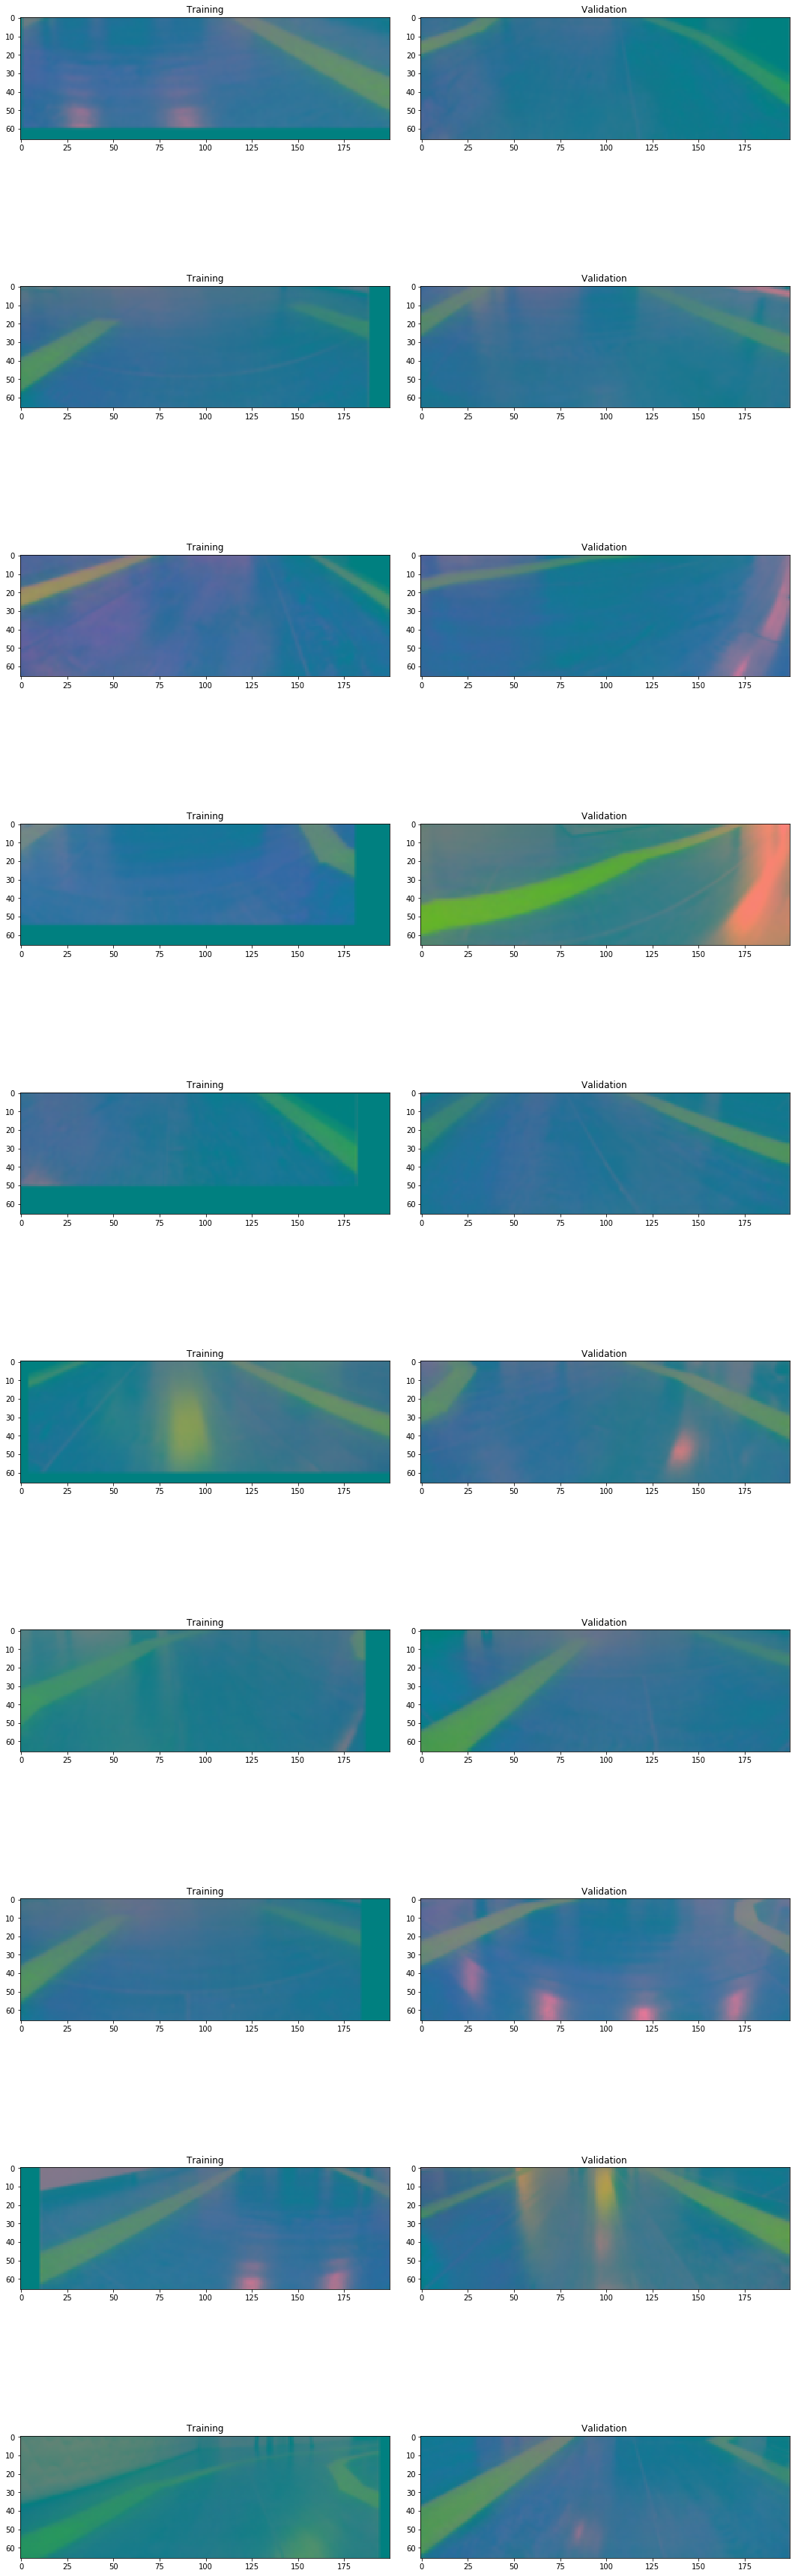

In [6]:
def preprocess_image(image):
  image = image[int(0.6*240):,:,:] #crop out skyview
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
  image = cv2.GaussianBlur(image, (3,3), 0) #reduce noise
  image = cv2.resize(image, (200,66)) #resize to fit NVIDIA's input size
  image = image/255 #normalize each pixel
  return image

def batch_generator(image_paths, steering_angles, batch_size, is_training):
  while True:
    batch_image = []
    batch_steering = []
    for i in range(batch_size):
      randnum = random.randint(0, len(image_paths) - 1)
      image = cv2.imread(image_paths[randnum])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      steering_angle = steering_angles[randnum]
      if is_training:
        image, steering_angle = random_augment(image, steering_angle)
      image = preprocess_image(image)
      batch_image.append(image)
      batch_steering.append(steering_angle)
    yield (np.asarray(batch_image), np.asarray(batch_steering))

X_train_test, y_train_test = next(batch_generator(X_train, y_train, 10, 1))
X_valid_test, y_valid_test = next(batch_generator(X_valid, y_valid, 10, 0))

cols = 2
rows = 10


fig, axes = plt.subplots(rows, cols, figsize=(15, 50))
fig.tight_layout()

for i in range(rows):
  axes[i][0].imshow(X_train_test[i])
  axes[i][0].set_title("Training")

  axes[i][1].imshow(X_valid_test[i])
  axes[i][1].set_title("Validation ")


Create the NVIDIA model and compile it to fit our data

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

Text(0.5, 0, 'epochs')

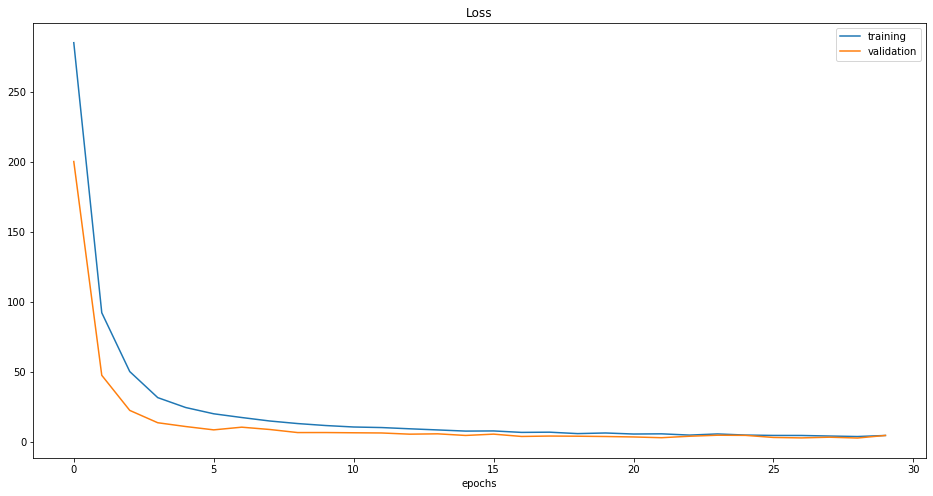

In [9]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation="elu"))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation="elu"))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation="elu"))
  model.add(Convolution2D(64, (3, 3), activation="elu"))
  #model.add(Dropout(0.5))

  model.add(Convolution2D(64, (3, 3), activation="elu"))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation="elu"))
  #model.add(Dropout(0.5))


  model.add(Dense(50, activation="elu"))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation="elu"))
  #model.add(Dropout(0.5))

  model.add(Dense(1))

  model.compile(loss='mse', optimizer=Adam(lr=1e-3))
  return model


model = nvidia_model()
print(model.summary())

output_dir = TRAINING_PATH + "/training"

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=output_dir + '/lane_navigation_checkv2.h5', verbose=1, save_best_only=True)

history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, epochs=30, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200, verbose=1, shuffle=1, callbacks=[checkpoint_callback])

model.save(output_dir + "/lane_navigation_finalv2.h5")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("epochs")


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    
def predict_and_summarize(X, Y):
    model = load_model(output_dir + '/lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred
  
n_tests = 100
X_test, y_test = next(batch_generator(X_valid, y_valid, n_tests, False))
y_pred = predict_and_summarize(X_test, y_test)

mse       = 1.5
r_squared = 98.77%
